In [1]:
import tensorflow as tf
from sklearn.datasets import load_sample_image
import numpy as np
import matplotlib.pyplot as plt

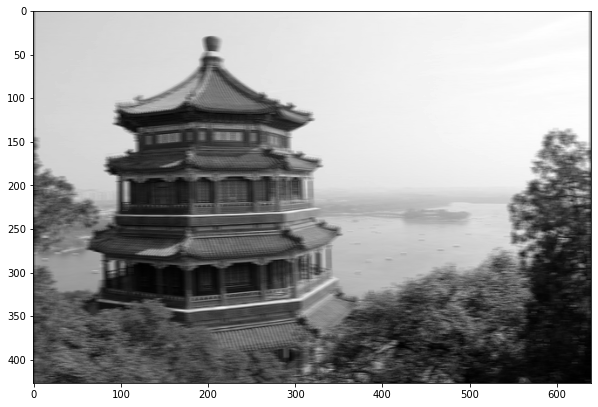

In [3]:
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1 # vertical line
filters[3, :, :, 1] = 1

outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")
plt.figure(figsize=(10, 7))
plt.imshow(outputs[0, :, :, 1], cmap="gray")
plt.show()

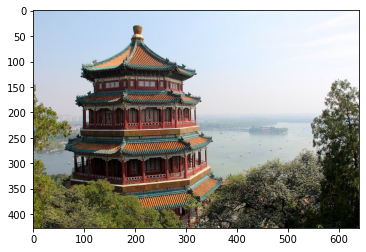

In [9]:
plt.imshow(china)

In [10]:
conv = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, 
                              padding="same", activation="relu")

In [2]:
max_pool = tf.keras.layers.MaxPool2D(pool_size=2)
avg_pool = tf.keras.layers.AvgPool2D(pool_size=2)

In [5]:
# depthwise Max Pooling
output = tf.nn.max_pool(images, 
                        ksize=(1, 1, 1, 3), 
                        strides=(1, 1, 1, 3), 
                        padding="VALID")

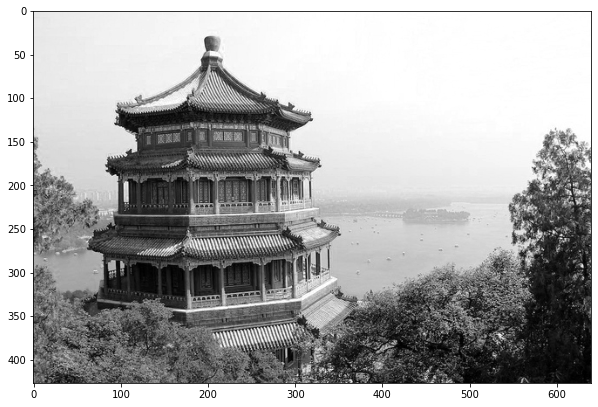

In [12]:
plt.figure(figsize=(10, 7))
plt.imshow(output[0, :, :, :], cmap="gray")
plt.show()

In [9]:
output.shape

TensorShape([2, 427, 640, 1])

In [13]:
depth_max_pool = tf.keras.layers.Lambda(lambda x: tf.nn.max_pool(x, 
                                                                 ksize=(1, 1, 1, 3), 
                                                                 strides=(1, 1, 1, 3), 
                                                                 padding="VALID"))